In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from MIOFlow.utils import generate_steps, set_seeds, config_criterion
from MIOFlow.models import make_model, Autoencoder
from MIOFlow.plots import plot_comparision, plot_losses
from MIOFlow.train import train_ae, training_regimen
from MIOFlow.constants import ROOT_DIR, DATA_DIR, NTBK_DIR, IMGS_DIR, RES_DIR
from MIOFlow.datasets import (
    make_diamonds, make_swiss_roll, make_tree, make_eb_data, 
    make_dyngen_data
)
from MIOFlow.geo import setup_distance
from MIOFlow.exp import setup_exp
from MIOFlow.eval import generate_plot_data

import os, pandas as pd, numpy as np, \
    seaborn as sns, matplotlib as mpl, matplotlib.pyplot as plt, \
    torch, torch.nn as nn

from tqdm.notebook import tqdm
import time

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Load dataset

In [3]:
#| export
def branch_data_clean(t, e):
    shapes = (len(e), len(t))
    t = t.reshape(1,-1)
    e = e.reshape(-1, 1)
    ts = np.tile(t, (shapes[0], 1))[...,None]
    es = np.tile(e, (1, shapes[1]))[...,None]
    x = np.tile(t, (shapes[0], 1))
    y = e * t**2
    data = np.stack([x,y], axis=2)
    data = np.concatenate((ts, es, data), axis=-1)
    data = data.reshape(shapes[0]*shapes[1], -1)
    return data
def branch_data_data(data, n_colors=5, repeats=5, noisex=0.05, noisey=0.05, seed=32):
    data = np.tile(data, (repeats,1))
    df = pd.DataFrame(data, columns=['t', 'e1', 'd1', 'd2'])
    np.random.seed(seed)
    df['d1'] += np.random.randn(df.shape[0]) * noisex
    df['d2'] += np.random.randn(df.shape[0]) * noisey
    _, bin_edges = np.histogram(df['t'], bins=n_colors)
    bin_indices = np.digitize(df['t'], bin_edges)
    bin_indices[bin_indices > n_colors] = n_colors
    df.insert(0, 'samples', bin_indices)
    df.drop(columns=['t'], inplace=True)
    df.samples -=1
    return df
def make_branch_cond(nt=20, ne=3, n_colors=5, repeats=10, noisex=0.1, noisey=0.1, seed=32):
    t = np.linspace(0,1,nt)
    e = np.linspace(-1,1,ne)
    data = branch_data_clean(t, e)
    df = branch_data_data(data, n_colors, repeats, noisex, noisey, seed)
    return df

df = make_branch_cond(ne=2, repeats=20)


In [4]:
df

,samples,e1,d1,d2
0,0,-1.0,-0.034889,0.054968
1,0,-1.0,0.151002,0.029287
2,0,-1.0,0.163355,-0.059603
3,0,-1.0,0.164923,-0.072056
4,1,-1.0,0.288280,-0.067361
...,...,...,...,...
795,3,1.0,0.932206,0.523483
796,4,1.0,0.930819,0.788406
797,4,1.0,1.034536,0.757093
798,4,1.0,0.839130,0.880604


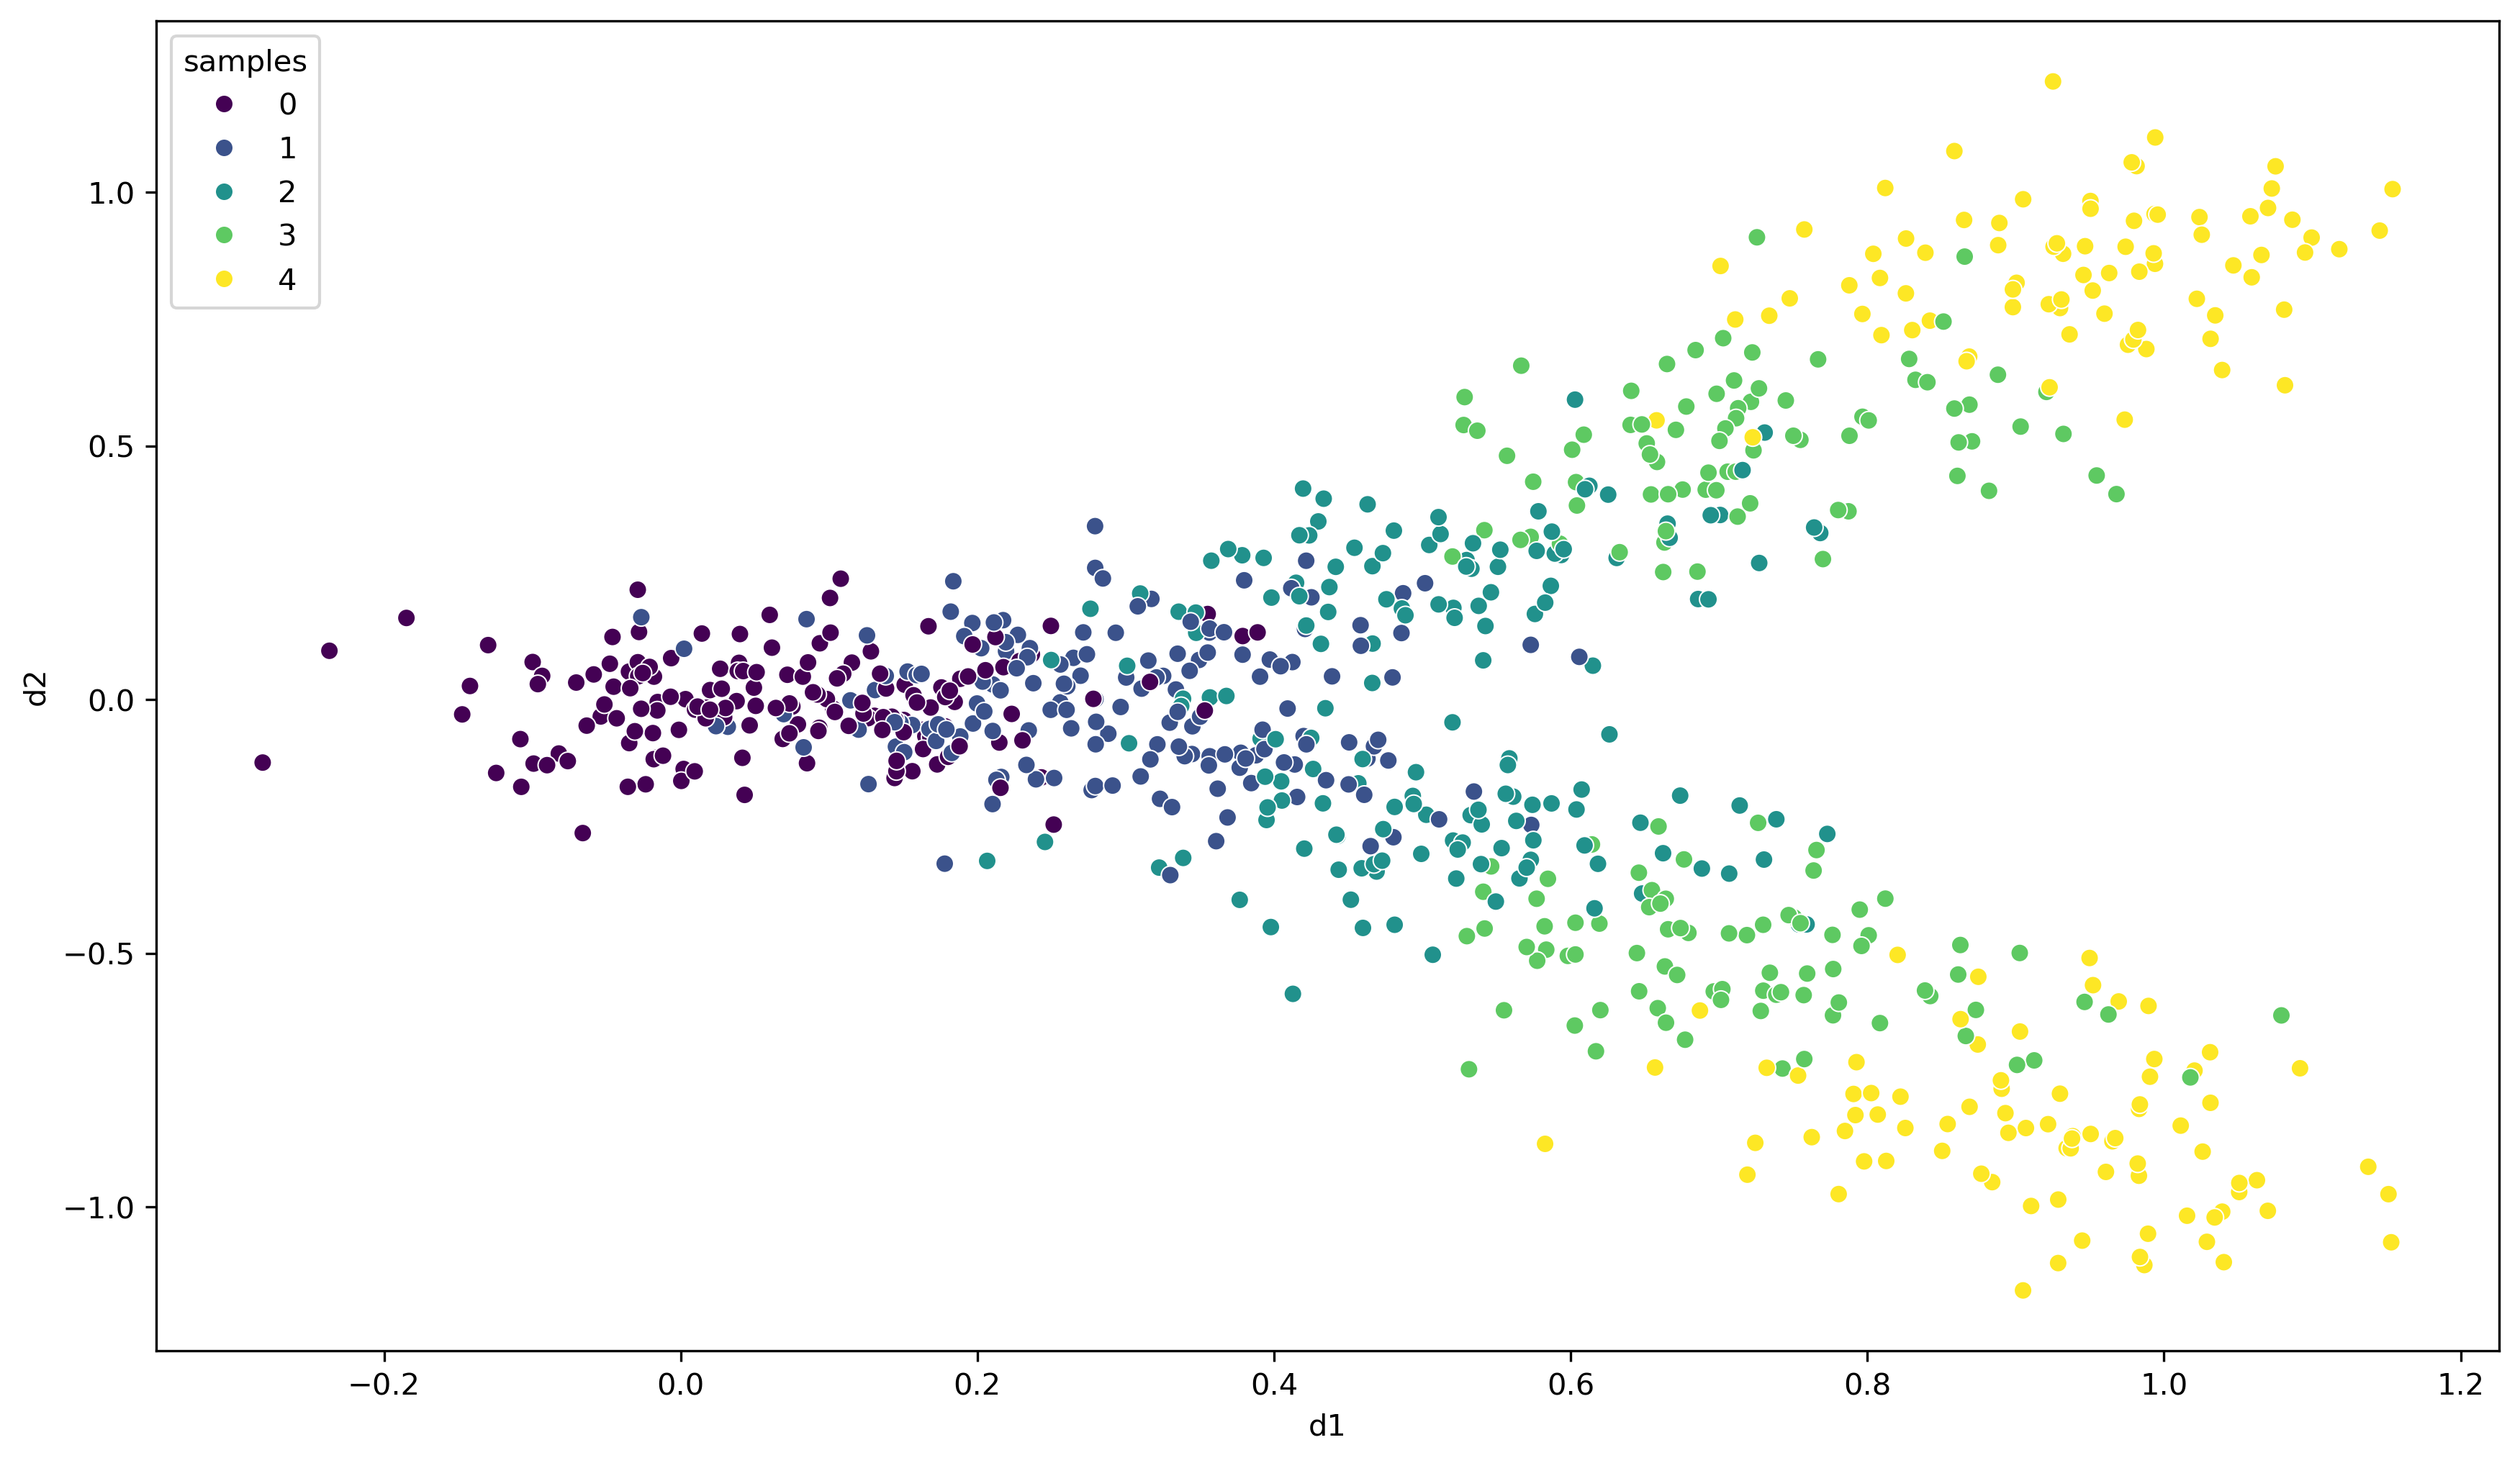

In [5]:
fig = plt.figure(figsize=(14, 8), dpi=300)
sns.scatterplot(data=df, x='d1', y='d2', hue='samples', palette='viridis');

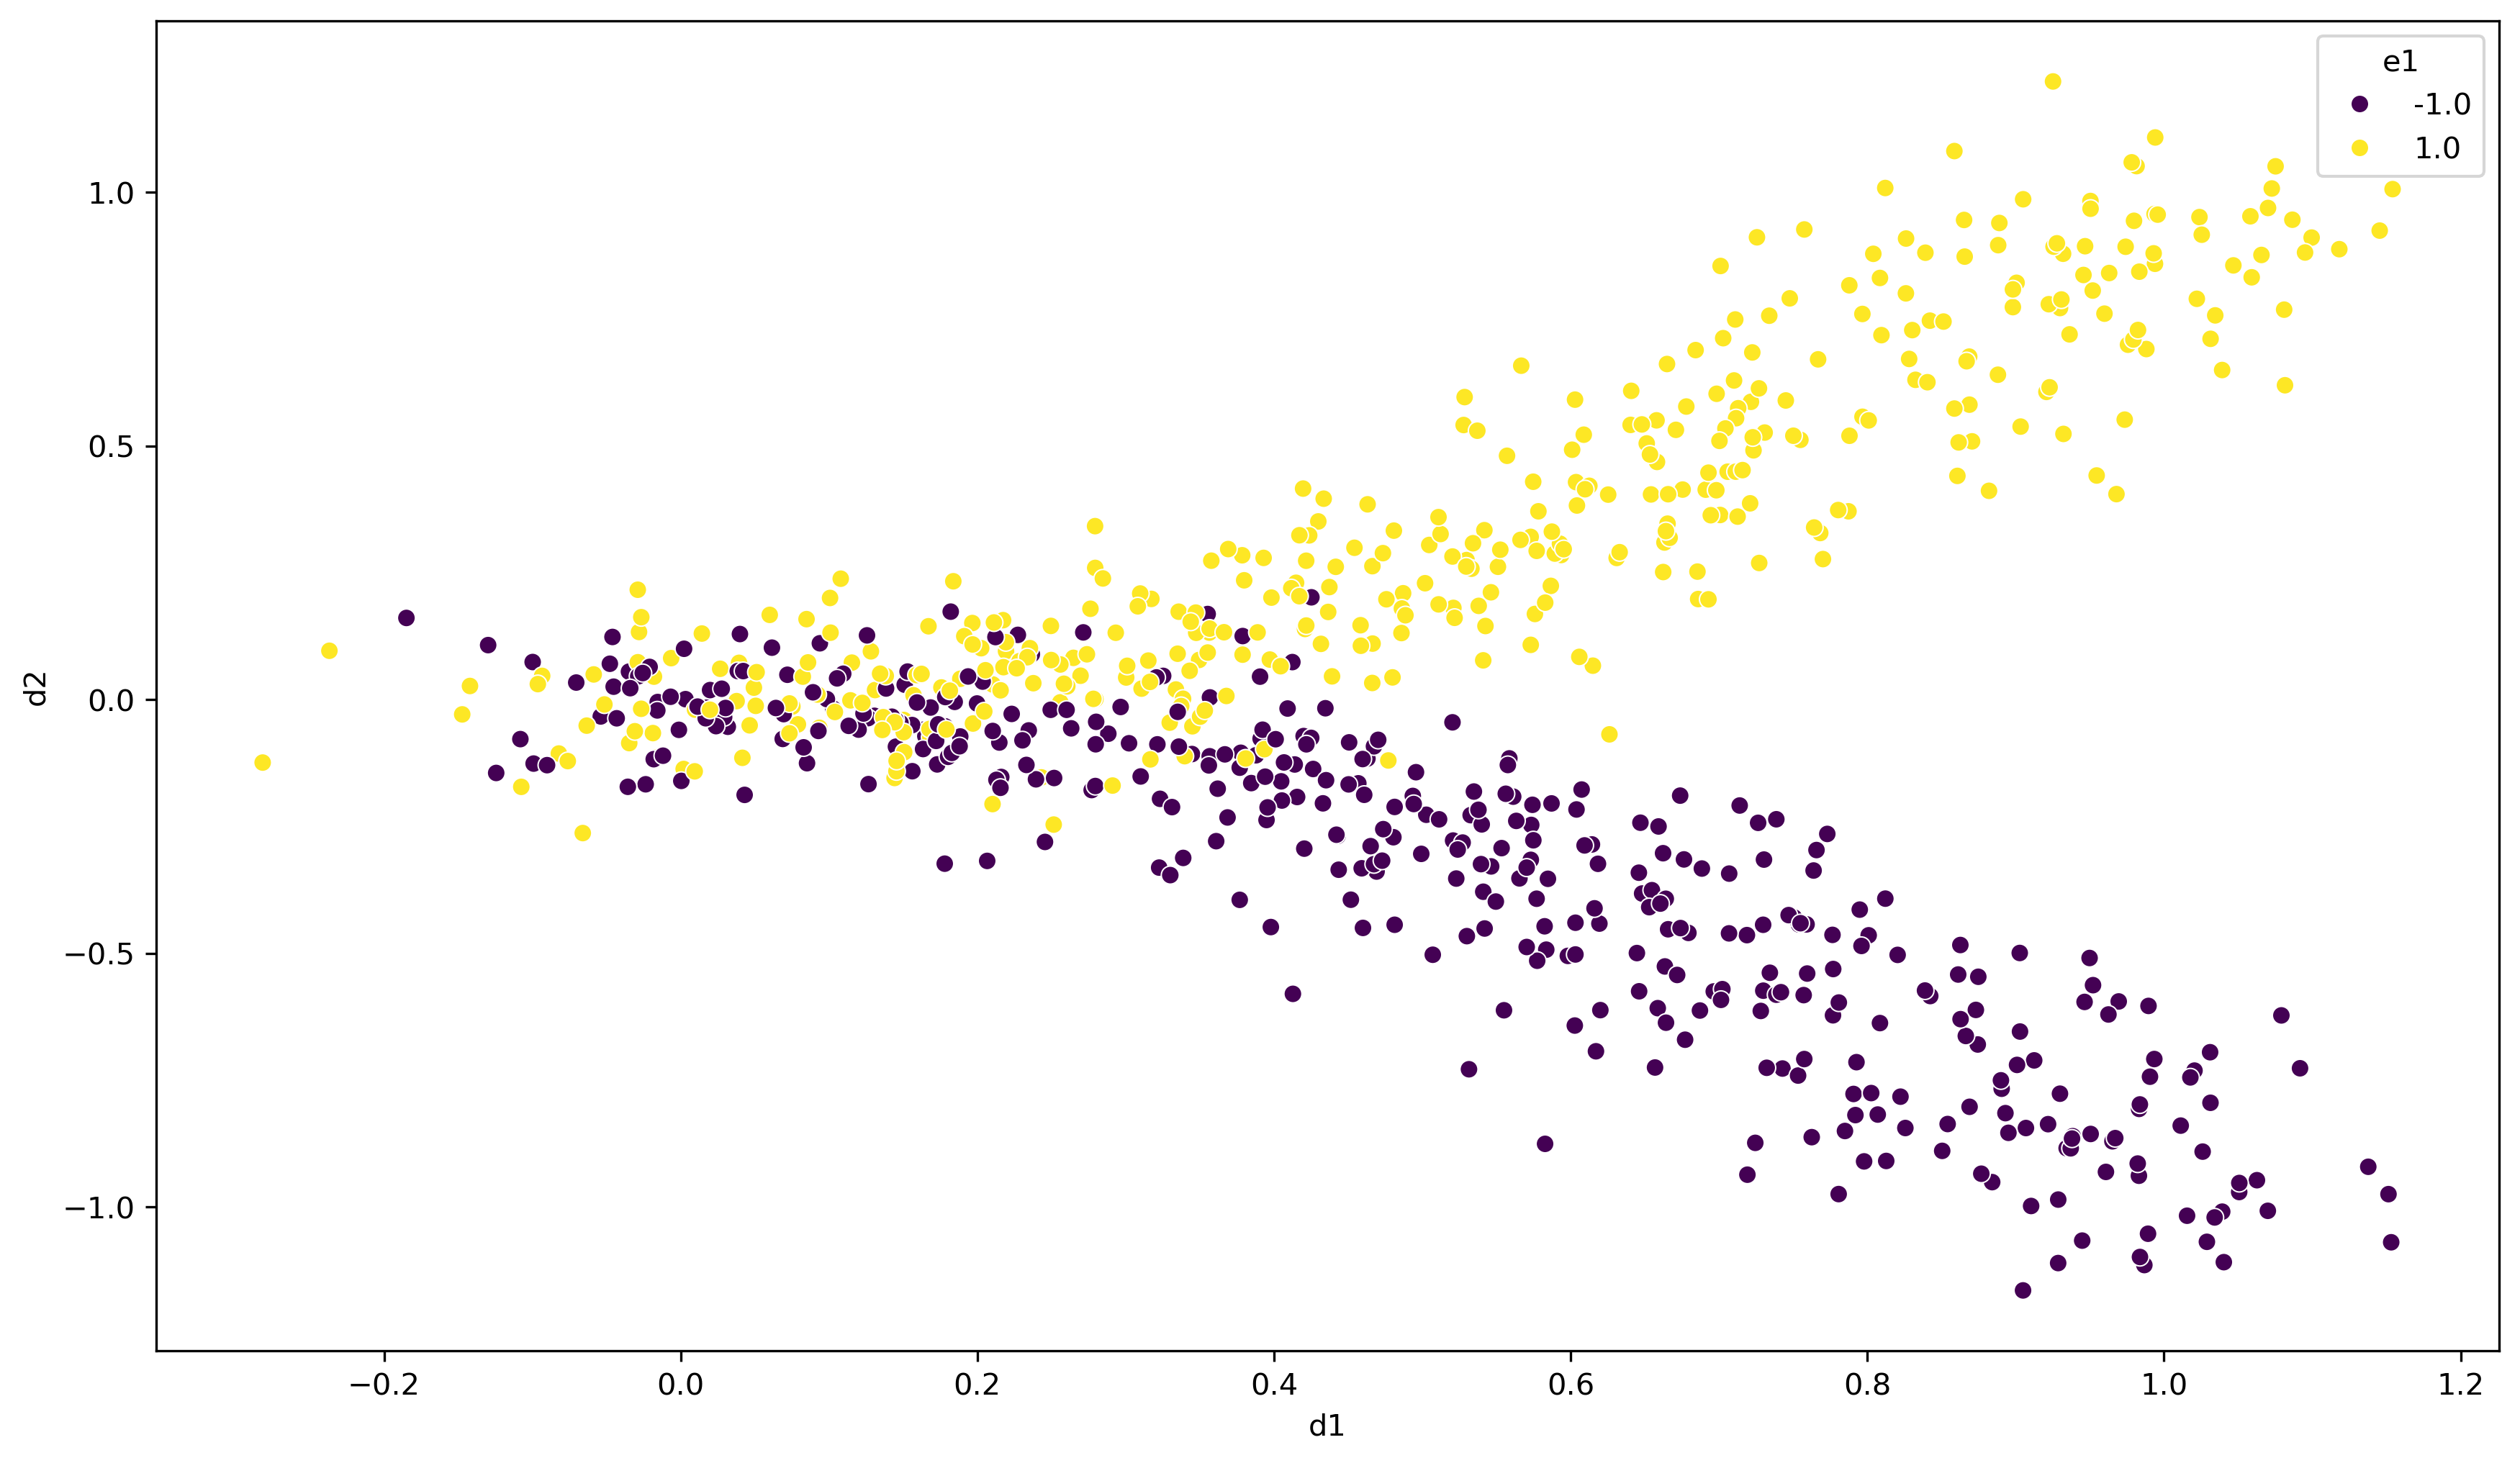

In [6]:
fig = plt.figure(figsize=(14, 8), dpi=300)
sns.scatterplot(data=df, x='d1', y='d2', hue='e1', palette='viridis');

In [7]:
df_copy = df.copy()
df = df.drop(columns=['e1'])

# Train autoencoder or the geodesic embedding

#### Set seeds and check GPU

In [8]:
set_seeds(0)
use_cuda = torch.cuda.is_available()

#### Handle hold-out training condition

In [9]:
# This is True if we want to holdout (or skip) one timepoint during training. It is used to test the accuracy of the trajectories on unseen data.
hold_one_out = False
# It can be a group number or 'random', works in tandem with hold_one_out
hold_out = 3

# The dimensions in the input space, it is columns - 1 because we assume one column is equal to "samples".
model_features = len(df.columns) - 1
groups = sorted(df.samples.unique())

In [10]:
# These determine the logic flow for training: 
#   use_emb=True use_gae=False is only the encoder to match the approximation of the geodesic.
#   use_emb=False use_gae=True the full Geodesic Autoencoder (GAE), i.e. matching the geodesic and a reconstruction loss.
#   use_emb=False use_gae=False Is not using the GAE.
#   use_emb=True use_gae=True, is redundant and should raise an error. 
use_emb = False
use_gae = False

need_to_train_gae = (use_emb or use_gae) and use_emb != use_gae

# If the reconstruction loss needs to be computed.
recon = use_gae and not use_emb 

# These are training GAE hyperparameters needed for training
# Distance_type in ['gaussian', 'alpha_decay'], and Gaussian scale
distance_type = 'gaussian'
rbf_length_scale=0.1
dist = setup_distance(distance_type, rbf_length_scale=rbf_length_scale)

#Can be changed depending on the dataset
n_epochs_emb = 1000
samples_size_emb = (30, )

# Layers for the Geodesic Autoencoder
gae_embedded_dim = 3
encoder_layers = [model_features, 8, gae_embedded_dim]

gae = Autoencoder(
    encoder_layers = encoder_layers,
    decoder_layers = encoder_layers[::-1],
    activation='ReLU', use_cuda = use_cuda
)
optimizer = torch.optim.AdamW(gae.parameters())

#### Actually train the GAE

In [11]:
# Added in extra cell just for iterative programming / running of code
#   but could be added to code block above

if need_to_train_gae:
    start_time_geo = time.time()

    losses = train_ae(
        gae, df, groups, optimizer, 
        n_epochs=n_epochs_emb, sample_size=samples_size_emb,
        noise_min_scale=0.09, noise_max_scale=0.15, 
        dist=dist, recon=recon, use_cuda=use_cuda,
        hold_one_out=hold_one_out, hold_out=hold_out
    )
    run_time_geo = time.time() - start_time_geo

    print(run_time_geo)
    autoencoder = gae
else:
    autoencoder = None

# Specify parameters

In [12]:
set_seeds(10)

#Directory where results are saved
exp_name = 'test'

# density loss knn
use_density_loss = True

# Weight of density (not percentage of total loss)
lambda_density = 35

# For petal=LeakyReLU / dyngen=CELU
activation = 'LeakyReLU'

# Can change but we never really do, mostly depends on the dataset.
layers = [16,32,16]

# Scale of the noise in the trajectories. Either len(groups)*[float] or None. Should be None if using an adaptative ODE solver.
sde_scales = len(groups)*[0.1] 

if recon:    
    model_features = gae_embedded_dim

# model = make_model(
#     model_features, layers, which='sde', method='euler',
#     activation=activation, scales=sde_scales, use_cuda=use_cuda
# )

# model = make_model(
#     model_features, layers, which='sde', method='reversible_heun', sde_type='stratonovich', adjoint_method='adjoint_reversible_heun',
#     activation=activation, scales=sde_scales, use_cuda=use_cuda, use_norm=False
# )

model = make_model(
    model_features, layers, which='sde', method='euler', sde_type='ito', 
    activation=activation, scales=sde_scales, use_cuda=use_cuda, use_norm=False
)



In [13]:
model.norm

[]

In [14]:
# Basically "batch size"
sample_size=(60, )

# Training specification
n_local_epochs = 40
n_epochs = 0
n_post_local_epochs = 0

# Using the reverse trajectories to train
reverse_schema = True
# each reverse_n epoch
reverse_n = 2


criterion_name = 'ot'
criterion = config_criterion(criterion_name)

optimizer = torch.optim.AdamW(model.parameters())

# Bookkeeping variables
batch_losses = []
globe_losses = []
if hold_one_out and hold_out in groups:
    local_losses = {f'{t0}:{t1}':[] for (t0, t1) in generate_steps(groups) if hold_out not in [t0, t1]}
else:
    local_losses = {f'{t0}:{t1}':[] for (t0, t1) in generate_steps(groups)}

# For creating output.
n_points = 100
n_trajectories = 100
n_bins = 100


In [15]:
opts = {
    'phate_dims': 2,
    'use_cuda': use_cuda,
    'model_features': model_features,
    'exp_name': exp_name,
    'groups': groups,
    'sample_size': sample_size,
    'use_emb': use_emb,
    'n_local_epochs': n_local_epochs,
    'n_epochs': n_epochs,
    'n_post_local_epochs': n_post_local_epochs,
    'criterion_name': criterion_name,
    'hold_one_out': hold_one_out,
    'use_density_loss': use_density_loss,
    'n_points': n_points,
    'n_trajectories': n_trajectories,
    'n_bins': n_bins,
    'autoencoder': autoencoder,
    'activation_ode': activation,
    'layer': layers,
    'lambda_density':lambda_density,
    'use_gae': use_gae,
    'sde_scales': sde_scales,
    'hold_out':hold_out,
    'encoder_layers': encoder_layers,
    'n_epochs_emb': n_epochs_emb,
    'samples_size_emb': samples_size_emb,
    'recon': recon,
    'distance_type':distance_type,
    'rbf_length_scale':rbf_length_scale,
    'reverse_schema': reverse_schema,
    'reverse_n': reverse_n
}

In [16]:
exp_dir, logger = setup_exp(RES_DIR, opts, exp_name) 

In [17]:
start_time = time.time()
local_losses, batch_losses, globe_losses = training_regimen(
    # local, global, local train structure
    n_local_epochs=n_local_epochs, 
    n_epochs=n_epochs, 
    n_post_local_epochs=n_post_local_epochs,
    
    # where results are stored
    exp_dir=exp_dir, 

    # BEGIN: train params
    model=model, df=df, groups=groups, optimizer=optimizer, 
    criterion=criterion, use_cuda=use_cuda,
    
    hold_one_out=hold_one_out, hold_out=hold_out,
    
    use_density_loss=use_density_loss, 
    lambda_density=lambda_density,
    # lambda_density=10,
    
    autoencoder=autoencoder, use_emb=use_emb, use_gae=use_gae, 
    
    sample_size=sample_size, logger=logger,
    reverse_schema=False, reverse_n=reverse_n, # sde cant use reverse schema for now
    # use_penalty=True, 
    use_penalty=False, 
    lambda_energy=0.001,
    # END: train params

    plot_every=5,
    n_points=n_points, n_trajectories=n_trajectories, n_bins=n_bins, 
    #local_losses=local_losses, batch_losses=batch_losses, globe_losses=globe_losses
)
run_time = time.time() - start_time + run_time_geo if use_emb or use_gae else time.time() - start_time
logger.info(f'Total run time: {np.round(run_time, 5)}')

Pretraining Epoch:   0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0it [00:00, ?it/s]

Posttraining Epoch: 0it [00:00, ?it/s]

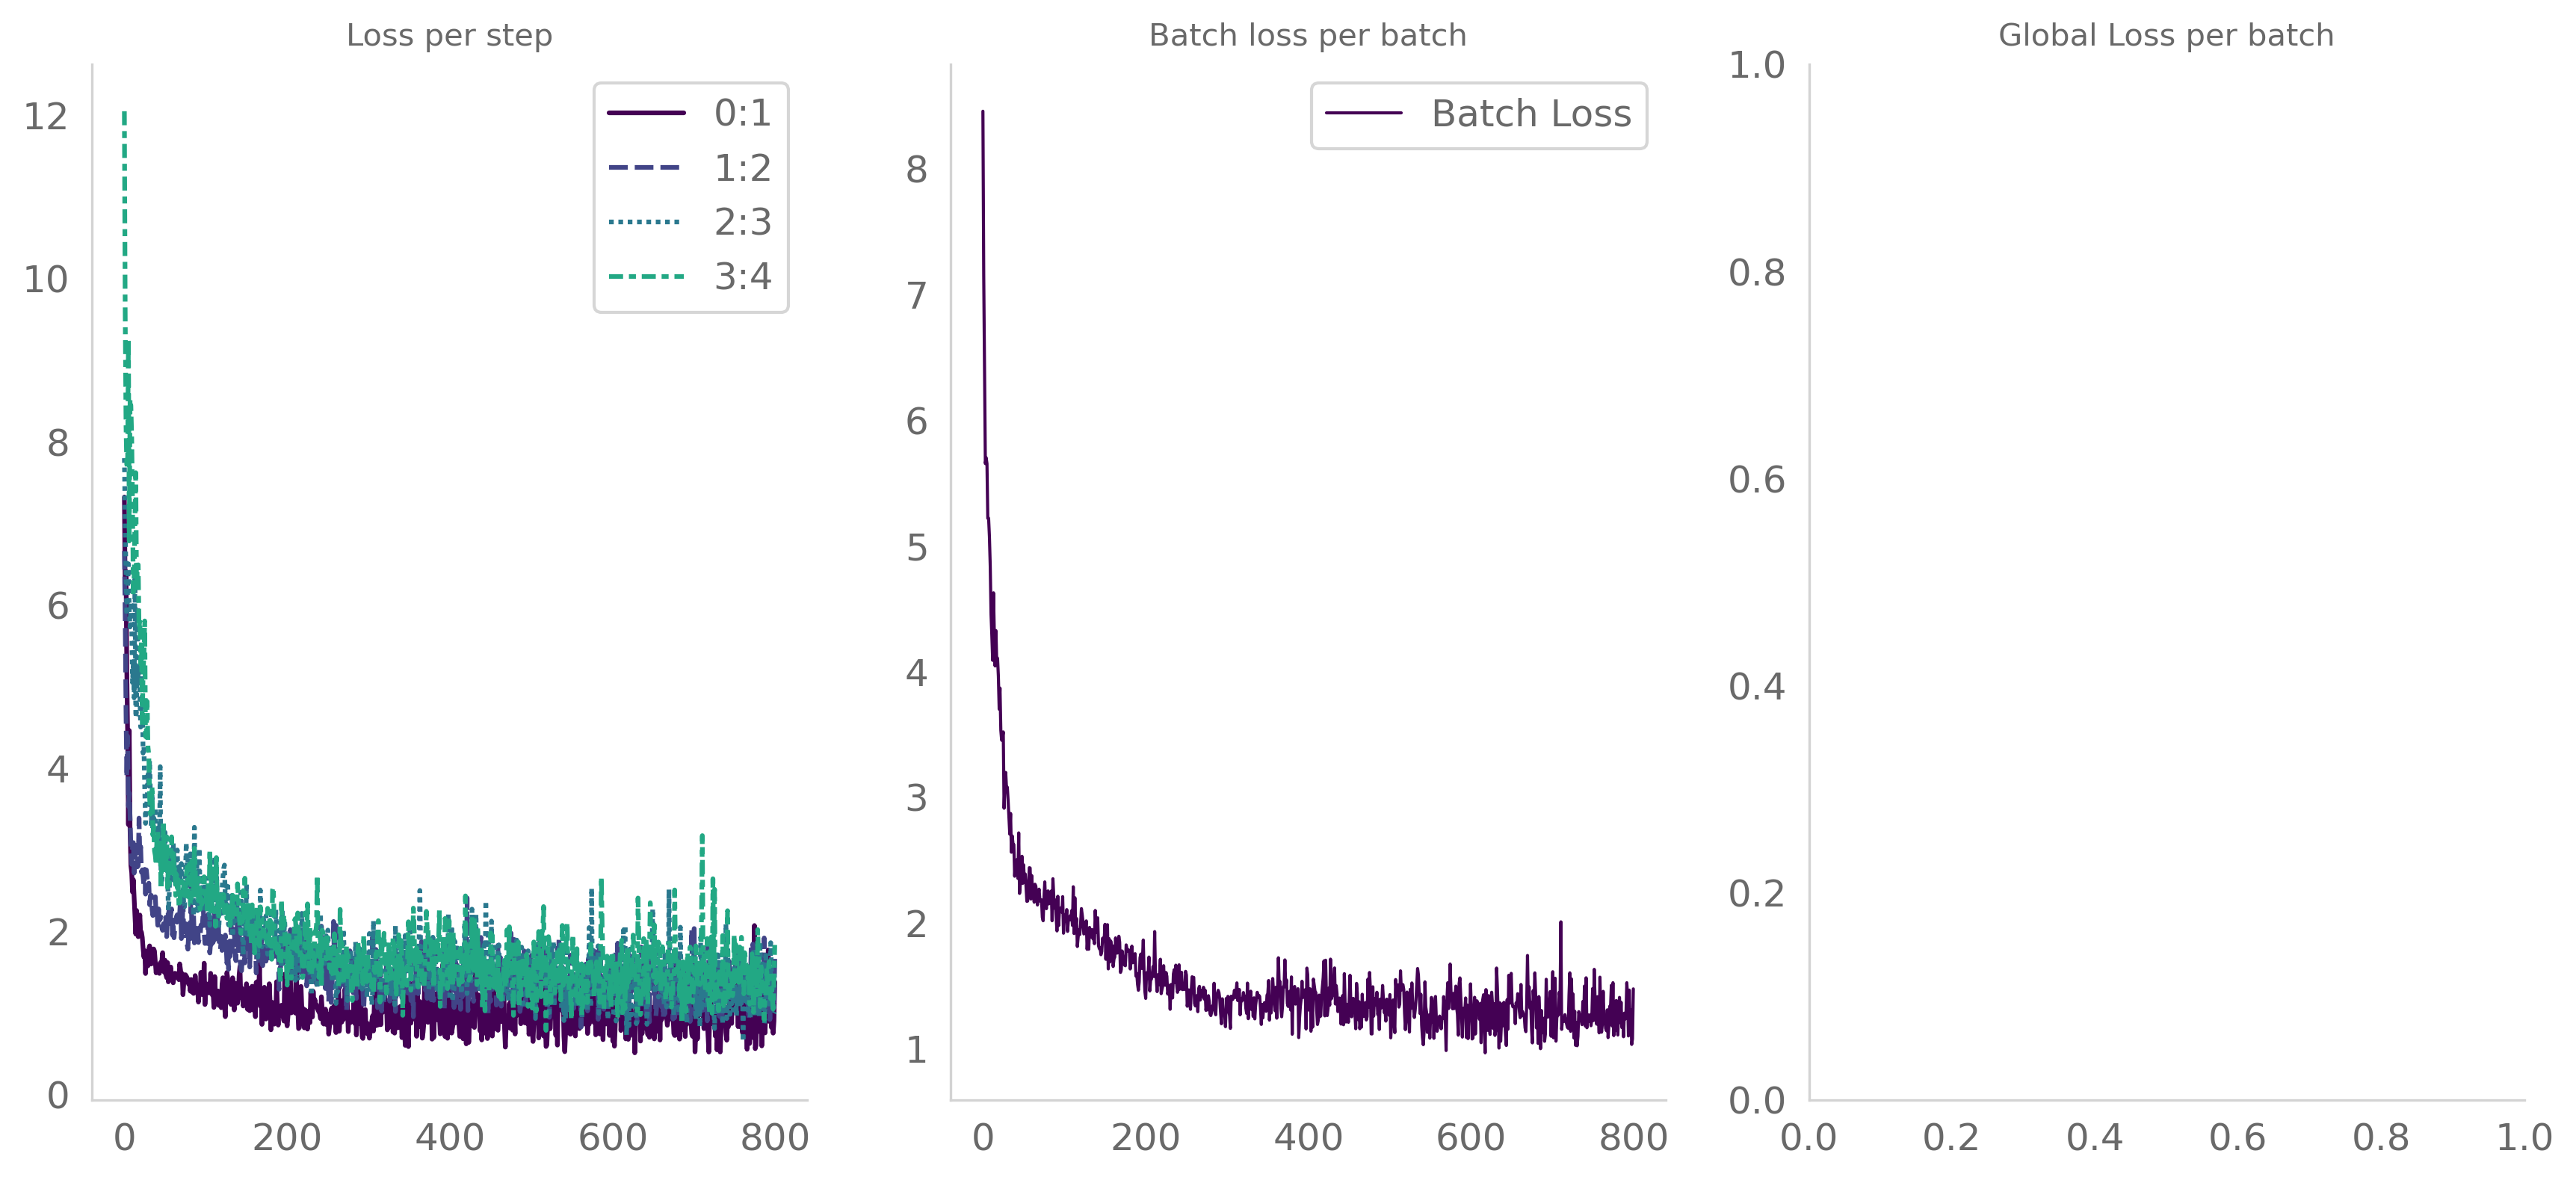

In [18]:
plot_losses(
    local_losses, batch_losses, globe_losses, 
    save=True, path=exp_dir, file='losses.png'
)

In [19]:
generated, trajectories = generate_plot_data(
    model, df, n_points, n_trajectories, n_bins, use_cuda=use_cuda, samples_key='samples', logger=logger,
    autoencoder=autoencoder, recon=recon
)

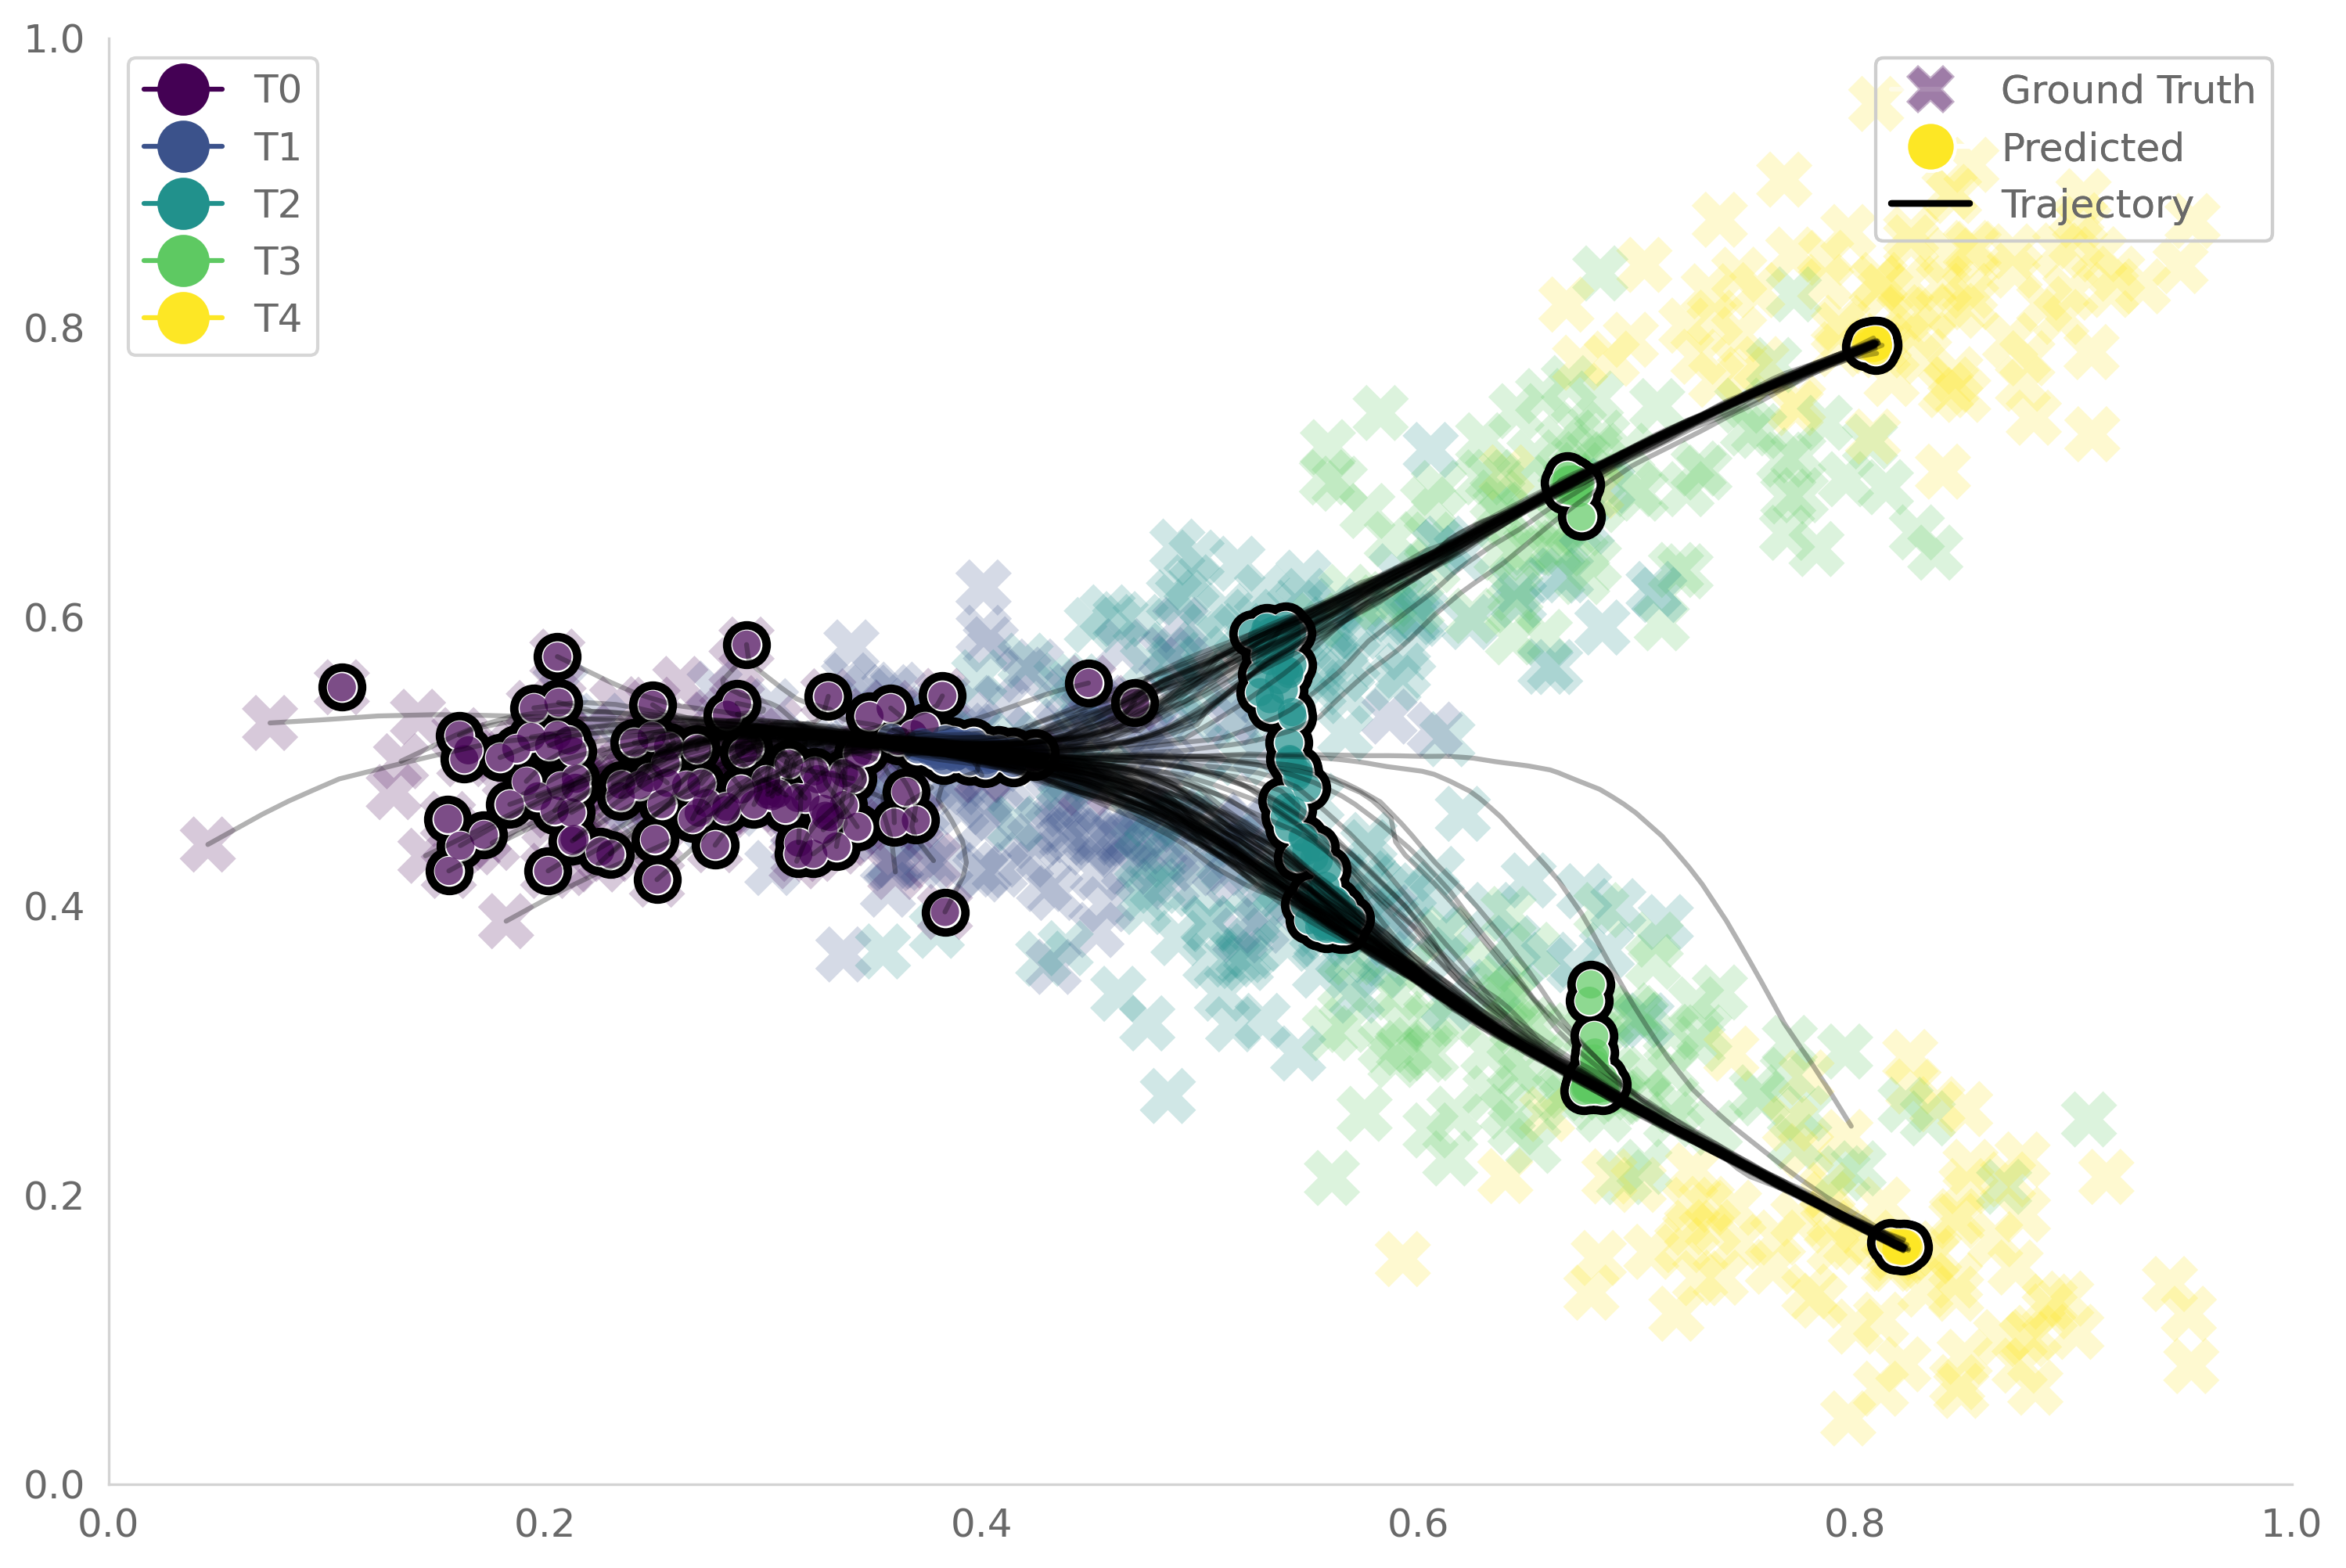

In [20]:
plot_comparision(
    df, generated, trajectories,
    palette = 'viridis', df_time_key='samples',
    save=True, path=exp_dir, file='2d_comparision.png',
    x='d1', y='d2', z='d3', is_3d=False
)

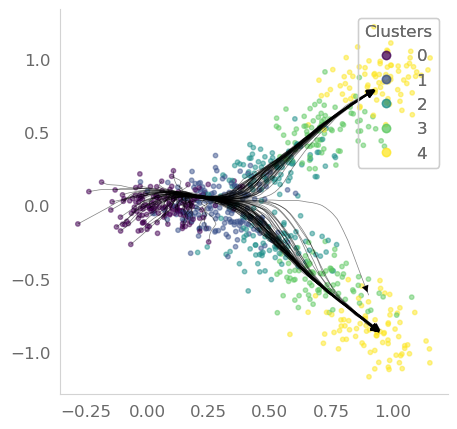

In [21]:
np.random.seed(32)
groups = sorted(df['samples'].unique())
sample_time = np.linspace(np.min(groups), np.max(groups), n_bins)
from MIOFlow.utils import sample
data_t0 = sample(
    df, np.min(groups), size=(n_points, ), 
    replace=False, to_torch=True, use_cuda=use_cuda
)
sample_time = torch.tensor(sample_time, dtype=data_t0.dtype, device=data_t0.device)

with torch.no_grad():
    x_traj = model(data_t0, sample_time, return_whole_sequence=True)

plt.figure(figsize=(5, 5))
scatter = plt.scatter(df['d1'], df['d2'],
                c=df['samples'] , cmap='viridis', s=10, alpha=.5)
# Add legend
legend1 = plt.legend(*scatter.legend_elements(),
                    loc="upper right", title="Clusters")
plt.gca().add_artist(legend1)
for i,traj in enumerate(np.transpose(x_traj, axes=(1,0,2))):
    # widths = m_traj[:,i]
    plt.plot(traj[:, 0], traj[:, 1], alpha=.5, linewidth=.5, color='Black');
    plt.annotate('', xy=(traj[-1, 0], traj[-1, 1]), xytext=(traj[-2, 0], traj[-2, 1]),
                 arrowprops=dict(arrowstyle="-|>", color='Black', lw=.1))

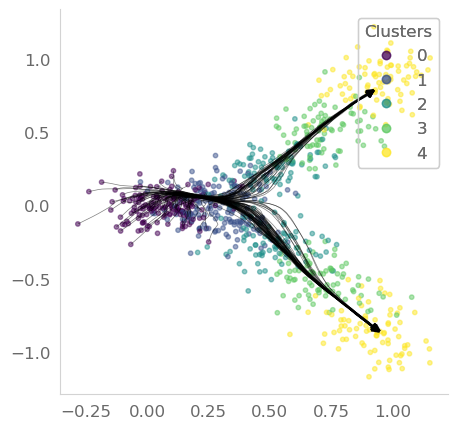

In [22]:
np.random.seed(32)
groups = sorted(df['samples'].unique())
sample_time = np.linspace(np.min(groups), np.max(groups), n_bins)
from MIOFlow.utils import sample
data_t0 = sample(
    df, np.min(groups), size=(n_points, ), 
    replace=False, to_torch=True, use_cuda=use_cuda
)
sample_time = torch.tensor(sample_time, dtype=data_t0.dtype, device=data_t0.device)

with torch.no_grad():
    x_traj = model(data_t0, sample_time, return_whole_sequence=True)

plt.figure(figsize=(5, 5))
scatter = plt.scatter(df['d1'], df['d2'],
                c=df['samples'] , cmap='viridis', s=10, alpha=.5)
# Add legend
legend1 = plt.legend(*scatter.legend_elements(),
                    loc="upper right", title="Clusters")
plt.gca().add_artist(legend1)
for i,traj in enumerate(np.transpose(x_traj, axes=(1,0,2))):
    # widths = m_traj[:,i]
    plt.plot(traj[:, 0], traj[:, 1], alpha=.5, linewidth=.5, color='Black');
    plt.annotate('', xy=(traj[-1, 0], traj[-1, 1]), xytext=(traj[-2, 0], traj[-2, 1]),
                 arrowprops=dict(arrowstyle="-|>", color='Black', lw=.1))

In [23]:
sample_time

tensor([0.0000, 0.0404, 0.0808, 0.1212, 0.1616, 0.2020, 0.2424, 0.2828, 0.3232,
        0.3636, 0.4040, 0.4444, 0.4848, 0.5253, 0.5657, 0.6061, 0.6465, 0.6869,
        0.7273, 0.7677, 0.8081, 0.8485, 0.8889, 0.9293, 0.9697, 1.0101, 1.0505,
        1.0909, 1.1313, 1.1717, 1.2121, 1.2525, 1.2929, 1.3333, 1.3737, 1.4141,
        1.4545, 1.4949, 1.5354, 1.5758, 1.6162, 1.6566, 1.6970, 1.7374, 1.7778,
        1.8182, 1.8586, 1.8990, 1.9394, 1.9798, 2.0202, 2.0606, 2.1010, 2.1414,
        2.1818, 2.2222, 2.2626, 2.3030, 2.3434, 2.3838, 2.4242, 2.4646, 2.5051,
        2.5455, 2.5859, 2.6263, 2.6667, 2.7071, 2.7475, 2.7879, 2.8283, 2.8687,
        2.9091, 2.9495, 2.9899, 3.0303, 3.0707, 3.1111, 3.1515, 3.1919, 3.2323,
        3.2727, 3.3131, 3.3535, 3.3939, 3.4343, 3.4747, 3.5152, 3.5556, 3.5960,
        3.6364, 3.6768, 3.7172, 3.7576, 3.7980, 3.8384, 3.8788, 3.9192, 3.9596,
        4.0000])

In [24]:
model.func(sample_time[-1], data_t0)

tensor([[ 1.7907e+00, -3.1783e-02],
        [ 2.0654e+00, -4.3683e-02],
        [ 2.0970e+00, -6.5024e-03],
        [ 1.9483e+00, -2.6210e-01],
        [ 2.1256e+00,  2.7820e-01],
        [ 1.8333e+00, -1.9643e-01],
        [ 1.7556e+00, -5.8479e-01],
        [ 1.7228e+00, -6.4259e-02],
        [ 2.1255e+00, -5.5441e-01],
        [ 1.8204e+00, -9.2999e-02],
        [ 1.8337e+00,  3.1333e-01],
        [ 2.1512e+00, -2.8248e-01],
        [ 1.6935e+00,  4.2905e-01],
        [ 1.6898e+00,  4.5651e-02],
        [ 1.9768e+00,  4.3298e-02],
        [ 2.0133e+00, -5.6389e-01],
        [ 2.0406e+00, -5.1627e-01],
        [ 2.0393e+00, -2.7206e-01],
        [ 1.8263e+00,  3.2175e-01],
        [ 1.5372e+00,  4.7414e-01],
        [ 1.9659e+00, -2.1733e-01],
        [ 1.7746e+00, -1.7556e-01],
        [ 1.8413e+00, -2.0099e-01],
        [ 1.8404e+00, -3.8159e-01],
        [ 1.6834e+00,  3.4970e-01],
        [ 2.0263e+00, -2.6205e-01],
        [ 2.1599e+00, -9.3931e-02],
        [ 1.9127e+00, -1.510

In [25]:
model.gunc(sample_time[-1], data_t0)

tensor([[ 0.0252, -0.1322],
        [ 0.0233, -0.0007],
        [-0.1114, -0.3682],
        [ 0.1409,  0.0203],
        [ 0.0433,  0.0375],
        [ 0.0809, -0.0125],
        [ 0.0965, -0.2247],
        [-0.1111, -0.0496],
        [ 0.0870, -0.0150],
        [ 0.0549, -0.0416],
        [ 0.0798,  0.0371],
        [-0.0359, -0.1130],
        [ 0.0577, -0.0798],
        [ 0.1110, -0.1218],
        [ 0.0694, -0.1172],
        [ 0.0091, -0.0376],
        [ 0.1329,  0.0468],
        [ 0.1811, -0.0518],
        [ 0.0818, -0.0747],
        [-0.1012,  0.2126],
        [-0.0996,  0.0355],
        [ 0.0168,  0.1249],
        [-0.0049, -0.0880],
        [ 0.0289,  0.0072],
        [ 0.0294,  0.2279],
        [-0.0181,  0.1016],
        [ 0.1697, -0.0098],
        [-0.1159,  0.0152],
        [ 0.1115,  0.0707],
        [ 0.0749,  0.0484],
        [ 0.0344, -0.0017],
        [ 0.0590,  0.2057],
        [-0.0934, -0.0253],
        [-0.0948,  0.0124],
        [ 0.0384,  0.1366],
        [ 0.1051,  0

In [26]:
# saving the trajectories and generated points
# np.save(os.path.join(exp_dir,'trajectories_petal.npy'),trajectories)
# np.save(os.path.join(exp_dir,'generated_petal.npy'),generated)

In [27]:
#Temporary fix for the logger
import logging
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

In [28]:
# To see the evolution of the scales before/after training. 
# for name, param in model.named_parameters():
#     if param.requires_grad:
#         print(name, param.data)

In [29]:
RES_DIR

'/vast/palmer/pi/krishnaswamy_smita/xingzhi/MIOFlow_conditional/results'

In [30]:
exp_dir

'/vast/palmer/pi/krishnaswamy_smita/xingzhi/MIOFlow_conditional/results/test'

In [31]:
# np.random.seed(32)
# groups = sorted(df['samples'].unique())
# sample_time = np.linspace(np.min(groups), np.max(groups), n_bins)
# from MIOFlow.utils import sample
# data_t0 = sample(
#     df, np.min(groups), size=(n_points, ), 
#     replace=False, to_torch=True, use_cuda=use_cuda
# )
# sample_time = torch.tensor(sample_time, dtype=data_t0.dtype, device=data_t0.device)

# with torch.no_grad():
#     x_traj = model(data_t0, sample_time, return_whole_sequence=True)

# savepath = './'
# np.save(os.path.join(savepath, 'trajectories.npy'), x_traj)

In [32]:
trajectories.shape

(100, 100, 2)

In [33]:
model2 = make_model(
    model_features, layers, which='sde', method='euler', sde_type='ito', 
    activation=activation, scales=sde_scales, use_cuda=use_cuda, use_norm=False
)

In [34]:
model2.gunc.seq[0].weight.data

tensor([[ 0.2437,  0.2797,  0.0570,  0.2779,  0.0347],
        [-0.1183,  0.0067,  0.4401,  0.3498, -0.1494],
        [ 0.4139,  0.0656, -0.0046, -0.1929, -0.1659],
        [-0.2156,  0.3183, -0.0187,  0.2119,  0.3075],
        [ 0.3266, -0.3321,  0.3833, -0.1310,  0.3567],
        [-0.0913,  0.3656, -0.1048, -0.0339, -0.1541],
        [ 0.0025, -0.1064,  0.3572,  0.3959, -0.2414],
        [-0.1638,  0.3917, -0.3346,  0.3917,  0.3871],
        [-0.4232, -0.2321,  0.2432,  0.4084, -0.1077],
        [ 0.3218,  0.2404,  0.0475, -0.3016, -0.3432],
        [ 0.2926,  0.0582,  0.4263, -0.1265, -0.2856],
        [ 0.3228,  0.3779,  0.2721, -0.2931, -0.2413],
        [-0.4404, -0.3370,  0.2876,  0.2884,  0.1277],
        [ 0.3419,  0.0170, -0.3606,  0.2216, -0.2695],
        [-0.3333,  0.2017, -0.2379, -0.0062, -0.0267],
        [-0.3256,  0.3410, -0.0317, -0.1099,  0.0156]])